In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [17]:
homebuyerDF = pd.read_csv('HomeBuyerInfo.csv')

homebuyerDF["LTV"] = homebuyerDF["LoanAmount"]/homebuyerDF["AppraisedValue"]
homebuyerDF["MonthlyDebt"] = homebuyerDF["CarPayment"] + homebuyerDF["CreditCardPayment"] + homebuyerDF["MonthlyMortgagePayment"] + homebuyerDF["StudentLoanPayments"]
homebuyerDF["DTI"] = homebuyerDF["MonthlyDebt"]/homebuyerDF["GrossMonthlyIncome"]
homebuyerDF["FEDTI"] = homebuyerDF["MonthlyMortgagePayment"]/homebuyerDF["GrossMonthlyIncome"]
#Add Approval Column
homebuyerDF["Approved"] = ""

"""
A potential buyer should be approved for home purchases iff:
CreditScore >= 640
LTV <= 0.8 is preferred
LTV > .8 and < .95 is approved but high risk (high interest rate)
DTI {
    .43 is hard cap
    .36 is soft cap
}

FEDTI <= .28

"""
#Approval is Y, R-LTV, R-DTI, N for HomebuyerDF
for i, row in homebuyerDF.iterrows():
    if (
        row["CreditScore"] >= 640 and
        row["LTV"] <= .8 and
        row["DTI"] <= .36 and
        row["FEDTI"] <= .28
    ):
        homebuyerDF.at[i, "Approved"] = "Y"
    elif (
        row["CreditScore"] >= 640 and
        row["LTV"] <= .95 and
        row["DTI"] <= .36 and
        row["FEDTI"] <= .28
    ):
        pmi = (homebuyerDF.at[i, 'AppraisedValue']*0.01)/12
        homebuyerDF.at[i, "MonthlyMortgagePayment"]+=pmi
        homebuyerDF.at[i, "MonthlyDebt"] += pmi
        homebuyerDF.at[i, "Approved"] = "R-LTV"
    elif (
        row["CreditScore"] >= 640 and
        row["LTV"] <= .8 and
        row["DTI"] <= .43 and
        row["FEDTI"] <= .28
    ):
        homebuyerDF.at[i, "Approved"] = "R-DTI"
    else:
        homebuyerDF.at[i, "Approved"] = "N"

        
#Save to CSV
homebuyerDF.to_csv("AnalyzedHomeBuyerInfo.csv", index=False)



OSError: [Errno 9] Bad file descriptor

In [18]:
homebuyerDF = pd.read_csv('AnalyzedHomeBuyerInfo.csv')

In [19]:
cc_md_pct = homebuyerDF["CreditCardPayment"]/homebuyerDF["MonthlyDebt"]
c_md_pct = homebuyerDF["CarPayment"]/homebuyerDF["MonthlyDebt"]
mm_md_pct = homebuyerDF["MonthlyMortgagePayment"]/homebuyerDF["MonthlyDebt"]

print(cc_md_pct.mean(), c_md_pct.mean(), mm_md_pct.mean())
print(cc_md_pct.median(), c_md_pct.median(), mm_md_pct.median())

0.1229118273591918 0.14933360366814608 0.613398192516889
0.11969824845773651 0.1466254218478656 0.6184868043147931


In [20]:

approvedDF = homebuyerDF[homebuyerDF["Approved"] == "Y"].drop(columns=["Approved", "ID"])
ltv_ristDF = homebuyerDF[homebuyerDF["Approved"] == "R-LTV"].drop(columns=["Approved", "ID"])
dti_riskDF = homebuyerDF[homebuyerDF["Approved"] == "R-DTI"].drop(columns=["Approved", "ID"])

all_approvedDF = homebuyerDF[homebuyerDF["Approved"] != "N"].drop(columns=["Approved", "ID"])

not_approvedDF = homebuyerDF[homebuyerDF["Approved"] == "N"].drop(columns=["Approved", "ID"])

df_list = [approvedDF, ltv_ristDF, dti_riskDF, not_approvedDF]

homebuyerDF["Approved"].value_counts()


N        7819
R-LTV    1023
Y         885
R-DTI     273
Name: Approved, dtype: int64

In [21]:
def breakdown_monthly_debt(dataframeVal):
    dataframeVal = pd.DataFrame(dataframeVal)
    # breakdown of monthly debt
    cc_md_pct = dataframeVal["CreditCardPayment"]/dataframeVal["MonthlyDebt"]
    c_md_pct = dataframeVal["CarPayment"]/dataframeVal["MonthlyDebt"]
    mm_md_pct = dataframeVal["MonthlyMortgagePayment"]/dataframeVal["MonthlyDebt"]

    print(cc_md_pct.mean(), c_md_pct.mean(), mm_md_pct.mean())
    print(cc_md_pct.median(), c_md_pct.median(), mm_md_pct.median())

In [22]:
for dfVal in df_list:
    breakdown_monthly_debt(dfVal)

0.14692126860888408 0.1791200226160059 0.5370657054699185
0.14360581137283424 0.1779586594296812 0.5345467537365277
0.12403668368142651 0.15349320513994205 0.6071568464199925
0.12180911012783072 0.152604121727865 0.6074864298146474
0.14312065486612718 0.17026438942819933 0.5560895662617273
0.14376131887007337 0.16973707488034728 0.5610415673876742
0.11934153788061179 0.14468718371840855 0.6248554636591517
0.11681265215666725 0.14172761339171894 0.6302478837702867


<Axes: >

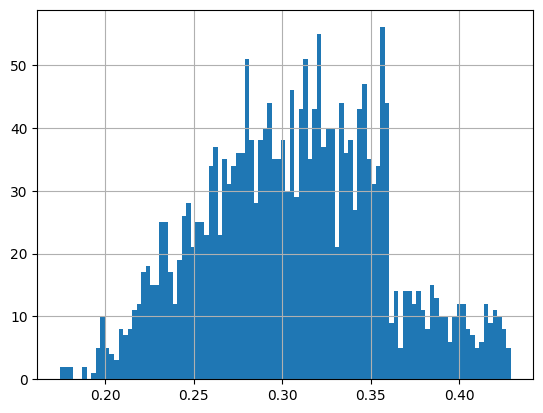

In [23]:
from scipy.stats import percentileofscore

# pVal = percentileofscore(all_approvedDF["LTV"], )
all_approvedDF["LTV"].describe()
all_approvedDF["DTI"].hist(bins=100)

In [24]:
#######################
'''
Return Categorical values for each of the features for rejection.
'''
#######################

categoricalDF = pd.DataFrame()

categoricalDF["CreditValue"] = np.where(homebuyerDF["CreditScore"] < 640, "Bad", "Good")
categoricalDF["DownPaymentValue"] = np.where(homebuyerDF["LTV"] < 0.8, "Good", "Bad")
cnd = [homebuyerDF["DTI"] < 0.36, homebuyerDF["DTI"] < 0.43, homebuyerDF["DTI"] >= 0.43]
vals = ["Good", "Mid", "Bad"]
categoricalDF["DebtValue"] = np.select(cnd, vals)
categoricalDF["HousingDebtValue"] = np.where(homebuyerDF["FEDTI"] <= 0.28, "Good", "Bad")

categoricalDF

,CreditValue,DownPaymentValue,DebtValue,HousingDebtValue
0,Good,Bad,Bad,Bad
1,Bad,Bad,Bad,Bad
2,Good,Bad,Bad,Bad
3,Good,Bad,Good,Good
4,Bad,Bad,Bad,Bad
...,...,...,...,...
9995,Good,Good,Bad,Bad
9996,Good,Bad,Mid,Good
9997,Bad,Bad,Good,Good
9998,Good,Bad,Mid,Good


<Axes: >

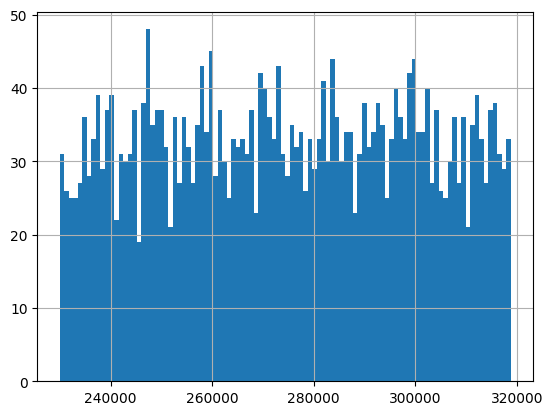

In [26]:
np.percentile(homebuyerDF["AppraisedValue"], [33, 66])
label = pd.qcut(homebuyerDF["AppraisedValue"], [0, 0.33, 0.66, 1], labels=["Low", "Medium", "High"])
homebuyerDF = homebuyerDF.assign(AppraisedValueLabel=label)
low = homebuyerDF[homebuyerDF["AppraisedValueLabel"] == "Low"]
low["AppraisedValue"].hist(bins=100)

In [44]:
from scipy.stats import percentileofscore

def compare_housevalue(house_appraisal, income):

    # all_approvedDF["GrossMonthlyIncome"].hist(bins=100)
    equivalent_percentile = percentileofscore(all_approvedDF["GrossMonthlyIncome"], income)
    print(equivalent_percentile)

    equivalent_appraisal = np.percentile(all_approvedDF["AppraisedValue"], equivalent_percentile)
    print(equivalent_appraisal)

    actual_appraisal_percentile = percentileofscore(all_approvedDF["AppraisedValue"], house_appraisal)
    print(actual_appraisal_percentile)

    income_appraisal_proportionality = np.where(equivalent_percentile < actual_appraisal_percentile, "below", "above")        
    print(income_appraisal_proportionality)


compare_housevalue(260000, 7000)



19.027968821641448
265310.0
16.139385602934432
above
